# Linear Regression

Section 3-5 covers underlying details of how linear regression is implemented and optimized.
- Section 3: Analytical solution
- Section 4: Gradient descent
- Section 5: Sochatic gradient descent and mini-batching

If you are interested in practical examples using `sklearn`, please refer to section 6 (linear regression) and section 7 (cross validation).

In [1]:
import copy
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

cmap = plt.get_cmap("tab10")
colors = [cmap(i) for i in range(cmap.N)]

mpl.rcParams["font.size"] = 24
mpl.rcParams["lines.linewidth"] = 2

## 1. Install Dependencies and Download Dataset

The packages and dataset required in this assignment are the same as in previous homeworks, please skip this part if you have already installed dependencies and downloaded datasets correctly. 

In [ ]:
!pip install pandas matplotlib rdkit scikit-learn wget

!python -m wget https://raw.githubusercontent.com/deepchem/deepchem/master/datasets/delaney-processed.csv \
    --output delaney-processed.csv

## 2. Load Dataset

In [3]:
DELANEY_FILE = "delaney-processed.csv"
df = pd.read_csv(DELANEY_FILE)
print(f"Number of molecules in the dataset: {df.shape[0]}")

Number of molecules in the dataset: 1128


Text(0, 0.5, 'log solubility (mol/L)')

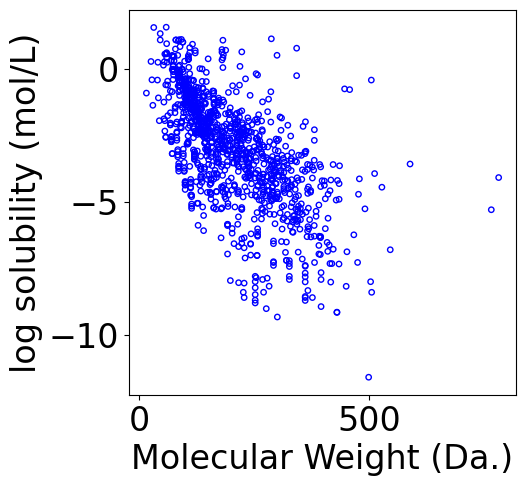

In [4]:
f, ax = plt.subplots(1, 1, figsize=(5,5))
ax.scatter(df[["Molecular Weight"]].values, 
           df["measured log solubility in mols per litre"].values, \
            s=15, marker='o', \
            facecolors='none', edgecolor="blue")

ax.set_xlabel("Molecular Weight (Da.)")
ax.set_ylabel("log solubility (mol/L)")

## 3. Analytical solution of Linear Regression

In [5]:
# since we are coding the analytical solution without using sklearn
# add bias term (all ones) to the input features
X = df[["Molecular Weight"]].values
X = X.reshape(-1, 1)
X = np.hstack([np.ones_like(X), X])

# ground truth
Y = df["measured log solubility in mols per litre"].values
Y = Y.reshape(-1, 1)

print("Shape of X:", X.shape)
print("Shape of Y:", Y.shape)

Shape of X: (1128, 2)
Shape of Y: (1128, 1)


In [6]:
theta = np.linalg.inv((X.T @ X)) @ (X.T @ Y)

In [7]:
theta

array([[-0.38596872],
       [-0.01306351]])

### Loss

In [8]:
y_pred = X @ theta
loss = np.mean((y_pred - Y)**2)
print(f"Loss: {loss}")

Loss: 2.5914815319019286


### Plot the regression line

Text(-6.152777777777777, 0.5, 'log solubility (mol/L)')

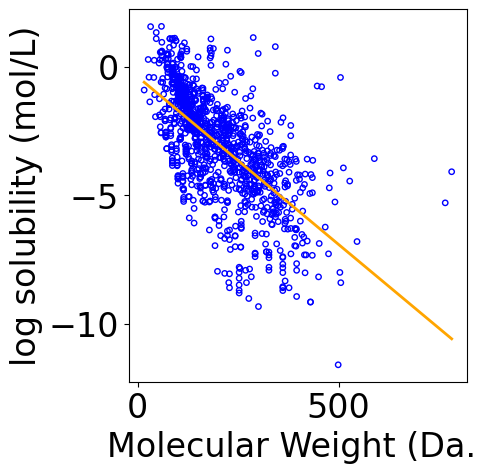

In [9]:
f, ax = plt.subplots(1, 1, figsize=(5,5))

plt.tight_layout()
ax.scatter(X[:, -1], Y.reshape(-1), \
            s=15, marker='o', \
            facecolors='none', edgecolor="blue")

min_X = np.min(X[:, -1])
max_X = np.max(X[:, -1])
x_line = np.linspace(np.floor(min_X), np.ceil(max_X), 100)
x_line = x_line.reshape(-1, 1)
x_line = np.hstack([np.ones_like(x_line), x_line])
y_pred_line = x_line @ theta

line, = ax.plot(x_line[:, -1], y_pred_line, color="orange", label="Fitted line")

ax.set_xlabel("Molecular Weight (Da.)")
ax.set_ylabel("log solubility (mol/L)")

### Plot Coefficient of Determination

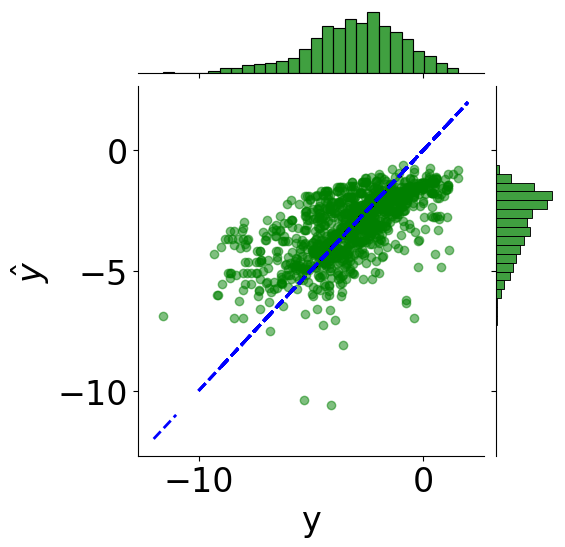

In [10]:
min_logS = np.min(Y)
max_logS = np.max(Y)
x_line = np.linspace(np.floor(min_logS), np.ceil(max_logS), 100)

tmp_df = pd.DataFrame({"y": Y.reshape(-1), r"$\hat{y}$": y_pred.reshape(-1)})

# scatter plot
g = sns.JointGrid(x="y", y=r"$\hat{y}$", data=tmp_df)
g = g.plot_joint(plt.scatter, c="green", alpha=0.5)

# line: y_pred = y
y_line = np.linspace(np.floor(Y.reshape(-1)), np.ceil(Y.reshape(-1)), 200)
g.ax_joint.plot(y_line, y_line, color="blue", linestyle="--");

# histograms
g = g.plot_marginals(sns.histplot, data=df, color="green", kde=False)

In [11]:
from sklearn.metrics import r2_score
print(f"Coefficient of determination: {r2_score(Y.reshape(-1), y_pred):.2f}")

Coefficient of determination: 0.41


## 4. Gradient Descent Solution of Linear Regression

### Data Normalization

It is very important to standardize/normalize data when using gradient descent. In order to reproduce the gradient descent without normalization plot in chapter 4, feel free to modify the code blocks and skip the normalization.

In [12]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
norm_mw = scaler.fit_transform(df[["Molecular Weight"]].values)
X = np.hstack([np.ones_like(norm_mw), norm_mw])

### Gradient Descent Fitting

In [13]:
lr = 1e-1

theta_list = []
loss_list = []
theta = np.array([0, 0]).reshape(-1, 1)
n_epochs = 20

for _ in range(n_epochs):
    theta_list.append(copy.deepcopy(theta))
    y_pred = X @ theta
    loss = np.mean((y_pred - Y).reshape(-1)**2)
    loss_list.append(loss)
    grad = 2*X.T @ (X @ theta - Y) / Y.shape[0]
    theta = theta - lr * grad

In [14]:
print("Final loss:", loss_list[-1])

Final loss: 2.593787495277282


The loss from gradient descent solution should be very close to the loss from the analytical solution, but may not be exact the same.

### Plot Training Curve

Text(0, 0.5, 'Loss')

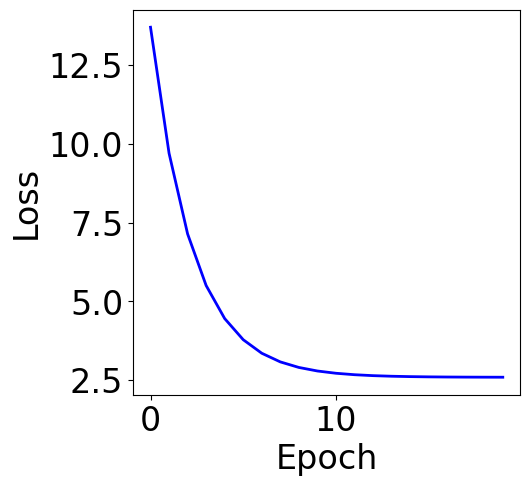

In [15]:
f, ax = plt.subplots(1, 1, figsize=(5,5))

ax.plot(loss_list, c="blue")
plt.xlabel("Epoch")
plt.ylabel("Loss")

### Plot Parameter Contour

In [16]:
def V(xx, yy):
    losses = []
    theta = np.hstack([xx.reshape(-1, 1), yy.reshape(-1, 1)])
    for i in range(theta.shape[0]):
        y_pred = X @ theta[i].reshape(-1, 1)
        loss = np.mean((y_pred - Y).reshape(-1)**2)
        losses.append(loss)
    return np.array(losses)

# calculate contour
t1 = np.arange(-6, 2, 1e-1)
t2 = np.arange(-4, 4, 1e-1)
xx, yy = np.meshgrid(t1, t2)
z = V(xx.ravel(), yy.ravel()).reshape(len(t2), -1)

Text(0, 0.5, '$\\theta_1$')

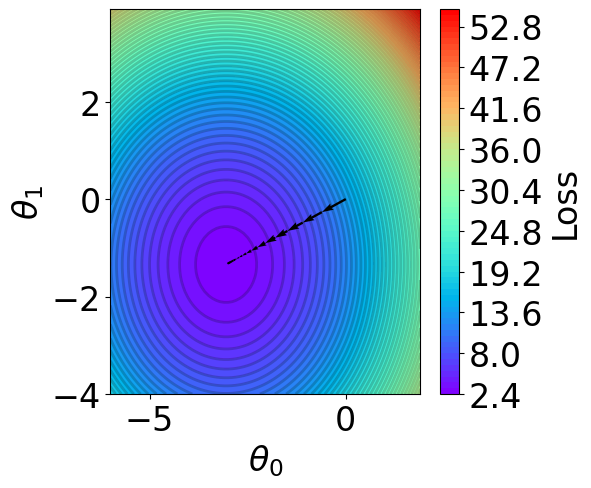

In [17]:
fig,ax = plt.subplots(1,1,figsize=(5,5))

n_levels = 75
c = ax.contourf(t1, t2, z, cmap='rainbow', levels=n_levels, zorder=1)
ax.contour(t1,t2, z, levels=n_levels, zorder=1, colors='black', alpha=0.2)
cb = fig.colorbar(c)
cb.set_label("Loss")

r=0.1
g=0.1
b=0.2
ax.patch.set_facecolor((r,g,b,.15))


# plot trajectory
for i in range(len(theta_list)-1):
    plt.quiver(theta_list[i][0], theta_list[i][1], # from point
               theta_list[i+1][0]-theta_list[i][0],  theta_list[i+1][1]-theta_list[i][1], # to point:
               angles="xy", scale_units="xy", scale=1, color="black",
               linewidth=1.5)


ax.set_xlabel(r'$\theta_0$')
ax.set_ylabel(r'$\theta_1$')

### Plot Iterative Procecss

The following code block outputs a `gif` file that shows the iterative update of the fitting curve. Jupyter notebook may only show the result of the last epoch, but you can open the file separately to see the animation.

C:\Users\24153\AppData\Local\Temp\ipykernel_36928\4040914613.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  legend = plt.legend(loc="upper right")


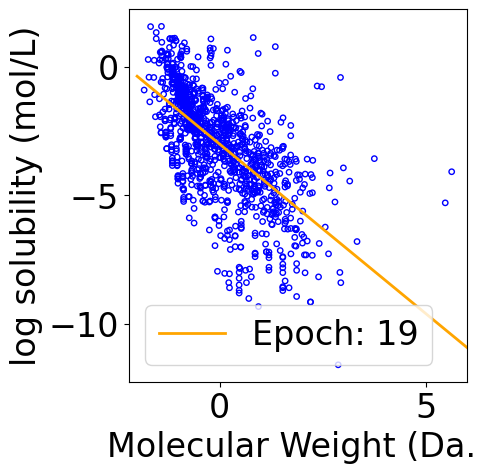

In [18]:
f, ax = plt.subplots(1, 1, figsize=(5, 5))

plt.tight_layout()
ax.scatter(X[:, -1], Y.reshape(-1), \
            s=15, marker='o', \
            facecolors='none', edgecolor="blue")

min_X = np.min(X[:, -1])
max_X = np.max(X[:, -1])
x_line = np.linspace(np.floor(min_X), np.ceil(max_X), 100)
x_line = x_line.reshape(-1, 1)
x_line = np.hstack([np.ones_like(x_line), x_line])

line, = ax.plot([], [], color="orange", label="")

ax.set_xlabel("Molecular Weight (Da.)")
ax.set_ylabel("log solubility (mol/L)")

legend = plt.legend(loc="upper right")

def animate(i):
    y_pred_line = x_line @ theta_list[i]
    line.set_data(x_line[:, -1], y_pred_line)
    line.set_label(f"Epoch: {i}")
    legend = plt.legend()
    return line, legend


ani = animation.FuncAnimation(f, animate, repeat=True, frames=len(theta_list), interval=100, blit=True)

writer = animation.PillowWriter(fps=10,
                                metadata=dict(artist='Me'),
                                bitrate=1800)
ani.save("theta_iteration.gif", writer=writer)

## 5. Stochastic Gradient Descent and Mini-batching

In [19]:
lr = 1e-1

theta_list = []
loss_list = []
theta = np.array([0, 0]).reshape(-1, 1)
n_epochs = 100
batch_size = 32 # change the batch size here

for _ in range(n_epochs):
    indices = np.random.choice(X.shape[0], batch_size, replace=False)
    theta_list.append(copy.deepcopy(theta))
    y_pred = X[indices, :] @ theta
    y_true = Y[indices]
    loss = np.mean((y_pred - y_true).reshape(-1)**2)
    loss_list.append(loss)
    grad = 2*X[indices, :].T @ (y_pred - y_true) / len(indices)
    theta = theta - lr * grad

In [20]:
print("Final loss:", pd.Series(loss_list).rolling(5).mean().iloc[-1])

Final loss: 2.1106429925056633


### Plot Training Curve

Text(0, 0.5, 'Loss')

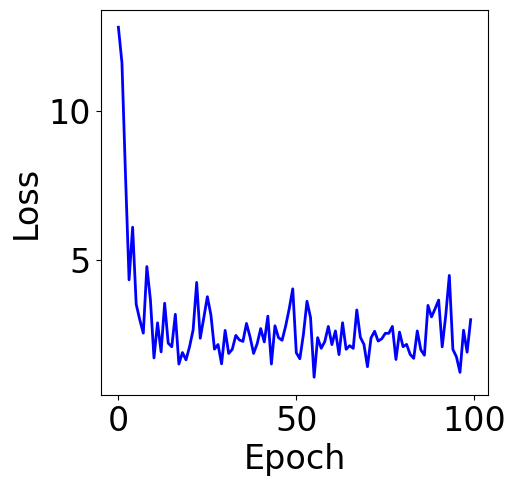

In [21]:
f, ax = plt.subplots(1, 1, figsize=(5,5))

ax.plot(loss_list, c="blue")
plt.xlabel("Epoch")
plt.ylabel("Loss")

### Parameter Contour

In [22]:
def V(xx, yy):
    losses = []
    theta = np.hstack([xx.reshape(-1, 1), yy.reshape(-1, 1)])
    for i in range(theta.shape[0]):
        y_pred = X @ theta[i].reshape(-1, 1)
        loss = np.mean((y_pred - Y).reshape(-1)**2) # mse
        losses.append(loss)
    return np.array(losses)

# calculate contour
region = np.stack(theta_list)

t1 = np.arange(-6, 2, 1e-1)
t2 = np.arange(-4, 4, 1e-1)
xx, yy = np.meshgrid(t1, t2)
z = V(xx.ravel(), yy.ravel()).reshape(len(t2), -1)

Text(0, 0.5, '$\\theta_1$')

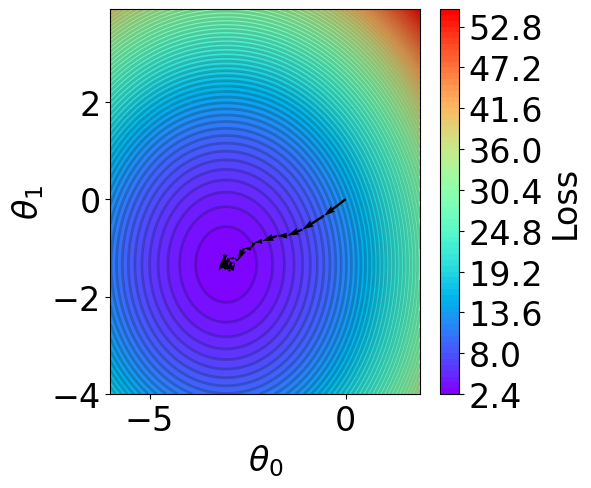

In [23]:
fig,ax = plt.subplots(1,1,figsize=(5,5))

# z = np.ma.masked_greater(z, 10)
n_levels = 75
c = ax.contourf(t1, t2, z, cmap='rainbow', levels=n_levels, zorder=1)
ax.contour(t1,t2, z, levels=n_levels, zorder=1, colors='black', alpha=0.2)
cb = fig.colorbar(c)
cb.set_label("Loss")

r=0.1
g=0.1
b=0.2
ax.patch.set_facecolor((r,g,b,.15))


# plot trajectory

for i in range(50):
    plt.quiver(theta_list[i][0], theta_list[i][1], # from point
               theta_list[i+1][0]-theta_list[i][0],  theta_list[i+1][1]-theta_list[i][1], # to point:
               angles="xy", scale_units="xy", scale=1, color="black",
               linewidth=1.5)


ax.set_xlabel(r'$\theta_0$')
ax.set_ylabel(r'$\theta_1$')

## 6. SKLearn Linear Regression

In [24]:
# features
# we don't have to add bias manually when using sklearn LinearRegression
X = df[["Molecular Weight"]].values
X = X.reshape(-1, 1)

# ground truth
Y = df["measured log solubility in mols per litre"].values
Y = Y.reshape(-1, 1)

### Fit Model

In [25]:
model = LinearRegression()
model.fit(X, Y)

LinearRegression()

In [26]:
print("Intercept:", model.intercept_)
print("Coefficients:", model.coef_)

Iintercept: [-0.38596872]
Coefficients: [[-0.01306351]]


The result from `sklearn` is the same as the analytical solution found in Section 2:
```
array([[-0.38596872],
       [-0.01306351]])
```

### Loss

In [27]:
from sklearn.metrics import mean_squared_error

y_pred = model.predict(X)
mse = mean_squared_error(Y, y_pred)
print(f"Loss: {mse}")

Loss: 2.5914815319019286


The loss from `sklearn` linear regression is also the same as the loss from the analytical solution.

### Visualize Results

Text(-6.152777777777777, 0.5, 'log solubility (mol/L)')

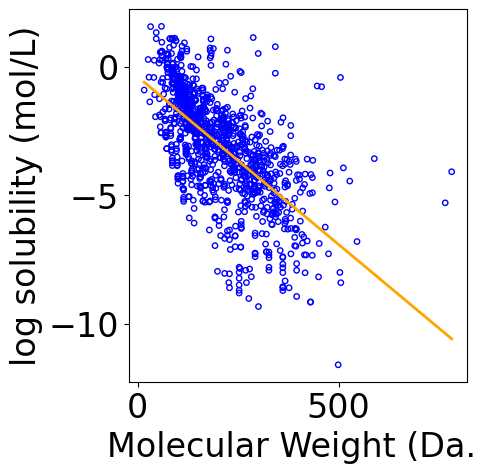

In [28]:
f, ax = plt.subplots(1, 1, figsize=(5,5))

plt.tight_layout()
ax.scatter(X, Y, \
            s=15, marker='o', \
            facecolors='none', edgecolor="blue")

min_X = np.min(X)
max_X = np.max(X)

x_line = np.linspace(np.floor(min_X), np.ceil(max_X), 100)
x_line = x_line.reshape(-1, 1)
y_pred_line = model.predict(x_line)

line, = ax.plot(x_line[:, -1], y_pred_line, color="orange", label="Fitted line")

ax.set_xlabel("Molecular Weight (Da.)")
ax.set_ylabel("log solubility (mol/L)")

## 7. Cross Validation and Model Selection

The previous sections use all the data for training. However, a good practice in machine learning is to split the data into training and validation sets. The training set is used to fit the model, while the validation set remains unseen during training and is used for evaluation. Cross-validation is a technique that helps reduce variance when assessing model performance.

In [29]:
# polynomial regression on one feature
X = df[["Molecular Weight"]].values

# ground truth
Y = df["measured log solubility in mols per litre"].values
Y = Y.reshape(-1, 1)

In [30]:
## k-fold split from sklearn
from sklearn.model_selection import KFold

In [31]:
# define train/validation on one fold
def run_one_fold(X_train, y_train, X_test, y_test, M, normalize=True):
    poly_features = PolynomialFeatures(degree=M)
    X_train_poly = poly_features.fit_transform(X_train)
    X_test_poly = poly_features.fit_transform(X_test)

    if normalize:
        scaler = StandardScaler()
        X_train_poly = scaler.fit_transform(X_train_poly)
        X_test_poly = scaler.transform(X_test_poly)
    else:
        scaler = None
    
    model = LinearRegression()
    model.fit(X_train_poly, y_train)
    
    # predict and calculate rmse of training dataset
    y_train_pred = model.predict(X_train_poly)
    mse_train = np.mean((y_train_pred-y_train)**2)
    
    # predict and calculate rmse of test dataset
    y_test_pred = model.predict(X_test_poly)
    mse_test = np.mean((y_test_pred-y_test)**2)
    return mse_train, mse_test

In [32]:
n_splits = 10 # 10-fold split
orders = [0, 1, 5, 10] # polynomial orders to scan

mse_train_list = []
std_train_list = []
mse_test_list = []
std_test_list = []

cv_df = pd.DataFrame(columns=["M", "MSE_train", "MSE_test"])

kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

for M in orders:
    mse_train_fold = []
    mse_test_fold = []
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        
        mse_train, mse_test = run_one_fold(X_train, y_train, X_test, y_test, M)
        mse_train_fold.append(mse_train)
        mse_test_fold.append(mse_test)
    
    mse_train_list.append(np.mean(mse_train_fold))
    std_train_list.append(np.std(mse_train_fold))
    mse_test_list.append(np.mean(mse_test_fold))
    std_test_list.append(np.std(mse_test_fold))

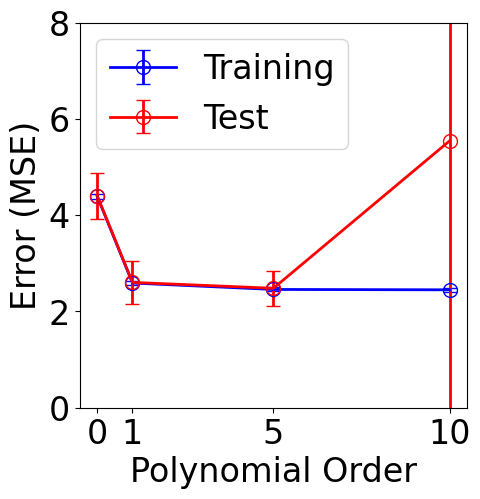

In [33]:
plt.figure(figsize=(5, 5))
plt.errorbar(orders, mse_train_list, yerr=std_train_list, color="b", \
    marker="o", markersize=10, markerfacecolor="none", markeredgecolor="b", 
    capsize=5, label="Training")
plt.errorbar(orders, mse_test_list, yerr=std_test_list, color="r", \
    marker="o", markersize=10, markerfacecolor="none", markeredgecolor="r", 
    capsize=5, label="Test")
plt.xlabel("Polynomial Order")
plt.ylabel("Error (MSE)")
plt.xticks(orders)
plt.ylim([0, 8])
plt.legend()